### 🌱Creating mock data for Meet Fresh customer-level ratings of ingredients
- [Amazon review data source](https://nijianmo.github.io/amazon/index.html#sample-review)
- [Movies rating data source](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=ratings.csv)


For building a recsys POC, customer-level rating data is one of the primary data sources needed. We explore two alternative data sources for creating mock data and select the most suitable. Mock data is then created so that it's adapted to Meet Fresh ingredient items.

In [ ]:
import pandas as pd
from google.cloud import storage
from io import BytesIO

client = storage.Client()
bucket_name = "meet-fresh-recommendation-system-data"
file_name = "Grocery_and_Gourmet_Food.csv"
bucket = client.get_bucket(bucket_name)
blob = bucket.get_blob(file_name)
content = blob.download_as_string()
amazon_df = pd.read_csv(BytesIO(content), header=None)

In [ ]:
amazon_df = amazon_df.rename(columns = {0:'item_id',1:'customer_id',2:'rating',3:'unix_review_time'})
amazon_df.head(10)

,item_id,customer_id,rating,unix_review_time
0,1888861614,ALP49FBWT4I7V,5.0,1370304000
1,1888861614,A1KPIZOCLB9FZ8,4.0,1400803200
2,1888861614,A2W0FA06IYAYQE,4.0,1399593600
3,1888861614,A2PTZTCH2QUYBC,5.0,1397952000
4,1888861614,A2VNHGJ59N4Z90,4.0,1397606400
5,1888861614,ATQL0XOLZNHZ4,1.0,1392940800
6,1888861614,A94ZG5CWN70E7,5.0,1385856000
7,1888861614,A3QBT8YC3CZ7C9,3.0,1383696000
8,1888861614,AGKW3A1RB1YGO,5.0,1380672000
9,1888861614,A1B65IWLUVOUQB,5.0,1378425600


#### Step 1: Scoping original dataset
Scope total dataset size, number of items and customers, and rating distributions to understand how to best adapt data to Meet Fresh

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5074160 entries, 0 to 5074159
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           object 
 1   customer_id       object 
 2   rating            float64
 3   unix_review_time  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 154.9+ MB


In [ ]:
# scoping counts and average counts
review_cnt = len(amazon_df)
item_cnt = amazon_df['item_id'].nunique()
customer_cnt = amazon_df['customer_id'].nunique()
review_per_item = review_cnt/item_cnt
review_per_customer = review_cnt/customer_cnt

print(f"Total ratings count: {review_cnt}")
print(f"Total items count: {item_cnt}")
print(f"Total customers count: {customer_cnt}")
print(f"Average rating count per item: {review_per_item:.2f}")
print(f"Average rating count per customer: {review_per_customer:.2f}")

Total ratings count: 5074160
Total items count: 283507
Total customers count: 2695974
Average rating count per item: 17.90
Average rating count per customer: 1.88


<AxesSubplot:>

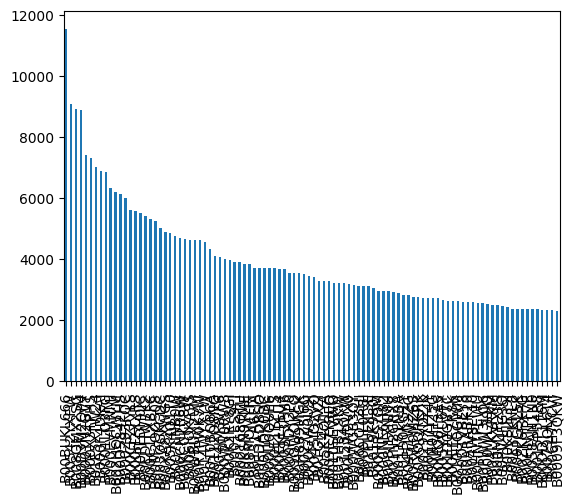

In [ ]:
# item rating count distribution follows an extremely long right tail
amazon_df['item_id'].value_counts()[:100].plot(kind='bar')

In [ ]:
amazon_df['item_id'].value_counts().describe()

count    283507.00000
mean         17.89783
std         107.50136
min           1.00000
25%           1.00000
50%           3.00000
75%           9.00000
max       11526.00000
Name: item_id, dtype: float64

In [ ]:
np.percentile(amazon_df['item_id'].value_counts(),99.9)

1273.9520000000484

<AxesSubplot:>

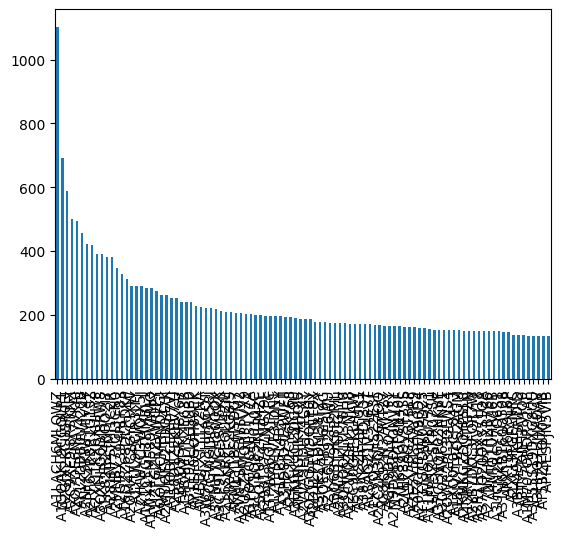

In [ ]:
# customer rating count distribution also follows an extremely long right tail
amazon_df['customer_id'].value_counts()[:100].plot(kind='bar')

In [ ]:
amazon_df['customer_id'].value_counts().describe()

count    2.695974e+06
mean     1.882125e+00
std      3.187802e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.103000e+03
Name: customer_id, dtype: float64

In [ ]:
np.percentile(amazon_df['customer_id'].value_counts(),99.99)

93.0

- Vast majority of items (75%) come with less than 10 ratings in total, and top 0.1% of items come with thousands of ratings. These could be top-selling products and/or products that are promoted with paid ratings.
- Vast majority of customers (75%) provide less than 2 ratings in total, and an extremely small proportion of customers (<0.001%) are associated with hundreds of ratings. These customers could be paid influencers for posting reviews for products.


In [ ]:
# overall rating value distributions
amazon_df['rating'].value_counts()

5.0    3573998
4.0     553201
1.0     405330
3.0     322134
2.0     219497
Name: rating, dtype: int64

In [ ]:
# rating value distributions for different percentile ranges
def rating_distributions(percentile_list, col):
    """
    function to create rating value distributions based on percentile range input
    
    input: - percentile_list is a list of percentile points defining range, i.e. [0,25,50,75,100]
           - col specifies column for running rating value distributions on
           
    output: dataframe with rating value distributions (count and rate) for different percentile ranges
    """
    c = len(percentile_list)
    df = pd.DataFrame([])
    
    for i in range(c-1):
        p1 = percentile_list[i]
        p2 = percentile_list[i + 1]
        item_list = col.value_counts()[
                    (col.value_counts() > np.percentile(col.value_counts(),p1))
                    & (col.value_counts() < np.percentile(col.value_counts(),p2))]
        item_list = item_list.index.to_list()
        s = amazon_df[col.isin(item_list)]['rating'].value_counts()
        s.name = f'{p1}-{p2}'
        df = df.append(s)
    
    df_norm = df.div(df.sum(axis=1), axis=0)
    return df, df_norm

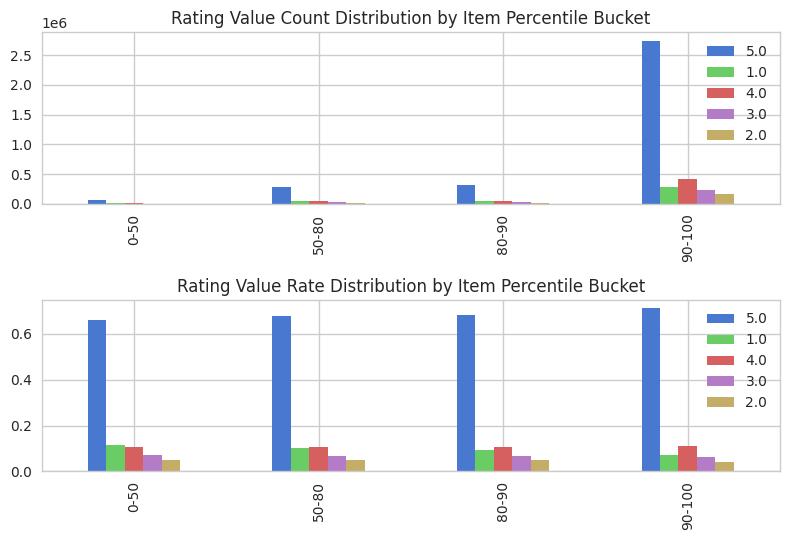

In [ ]:
# plot rating value distributions for item percentile ranges
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
# plt.figure(figsize=(12,3))

rating_distributions([0,50,80,90,100], col = amazon_df['item_id'])[0].plot(kind='bar',ax=ax1)
rating_distributions([0,50,80,90,100], col = amazon_df['item_id'])[1].plot(kind='bar',ax=ax2)

ax1.title.set_text('Rating Value Count Distribution by Item Percentile Bucket')
ax2.title.set_text('Rating Value Rate Distribution by Item Percentile Bucket')

plt.tight_layout()

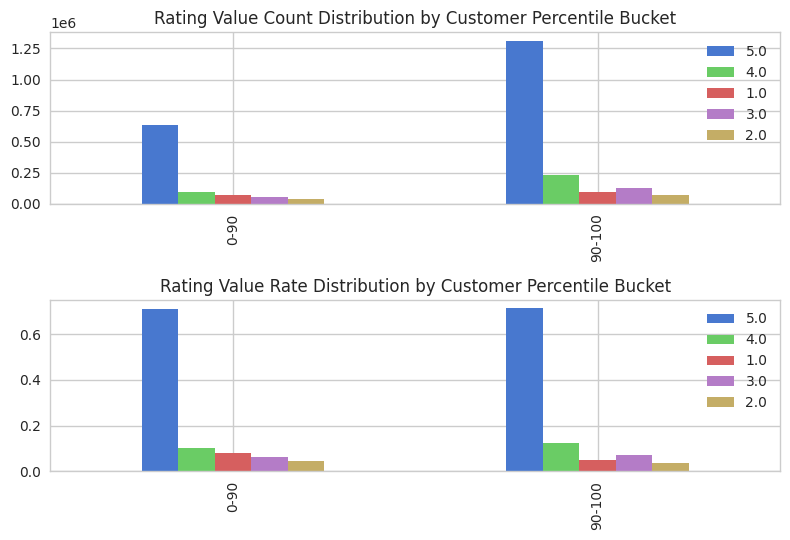

In [ ]:
# rating value distributions for customer percentile ranges
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
# plt.figure(figsize=(12,3))

rating_distributions([0,90,100], col = amazon_df['customer_id'])[0].plot(kind='bar',ax=ax1)
rating_distributions([0,90,100], col = amazon_df['customer_id'])[1].plot(kind='bar',ax=ax2)

ax1.title.set_text('Rating Value Count Distribution by Customer Percentile Bucket')
ax2.title.set_text('Rating Value Rate Distribution by Customer Percentile Bucket')

plt.tight_layout()

We now have an understanding of rating distributions from original dataset:
- there are a few extreme items that come with extremely high count of ratings and a few extreme customers that are giving out extremely high count of ratings.
- item rating value distributions are similar across percentile buckets 

#### Step 2: Select item_id and customer_id for mock dataset
- Select 24 reasonable items and an appropriate sample of customer_id to create mock dataset for Meet Fresh ingredient ratings

In [ ]:
# import random
# random.seed(10)

# items = amazon_df['item_id'].value_counts()[
#     (amazon_df['item_id'].value_counts() > np.percentile(amazon_df['item_id'].value_counts(),99.9))
#     # & (amazon_df['item_id'].value_counts() > np.percentile(amazon_df['item_id'].value_counts(),50))
#     ]
# items = items.index.to_list()

# mf_items = random.sample(items, 24)
# mf_ratings = amazon_df[amazon_df['item_id'].isin(mf_items)]

In [ ]:
# # adjust rating scale 1-5 to Meet Fresh rating scale 0-3
# rating_map = {1:0,2:0,3:1,4:2,5:3}
# mf_ratings['meetfresh_rating'] = mf_ratings['rating'].map(rating_map)
# mf_ratings

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,item_id,customer_id,rating,unix_review_time,meetfresh_rating
214240,B000EDDS6Q,A3R6PI47EF3F83,5.0,1165190400,3
214241,B000EDDS6Q,A1PJVPWL84EKH,5.0,1164758400,3
214242,B000EDDS6Q,A3HPZ6BIMNXSZR,5.0,1164585600,3
214243,B000EDDS6Q,A2DVBDD89B9WUU,5.0,1163030400,3
214244,B000EDDS6Q,A1ADHA5P7P7Q8N,5.0,1162512000,3
...,...,...,...,...,...
5049292,B01F2PYV20,A25WH4H0Q1SMTF,1.0,1537142400,0
5049293,B01F2PYV20,A37WWX1H709VVO,2.0,1537056000,0
5049294,B01F2PYV20,A232HRSC5R8ZDM,1.0,1536883200,0
5049295,B01F2PYV20,ARA5EH38LNJ4E,4.0,1536710400,2


In [ ]:
mf_ratings['meetfresh_rating'].value_counts()

3    41756
0     7610
2     6653
1     3658
Name: meetfresh_rating, dtype: int64

In [ ]:
%%bigquery dim_ingredient
SELECT * FROM `dsxl-ai-advanced-program.meetfresh.dim_ingredient`

Executing query with job ID: f90d344d-8bd4-4f9d-9cb0-227f92cb4d2d
Query executing: 0.26s


ERROR:
 404 Not found: Table dsxl-ai-advanced-program:meetfresh.dim_ingredient was not found in location US

Location: US
Job ID: f90d344d-8bd4-4f9d-9cb0-227f92cb4d2d



### Creating mock data for Meet Fresh customer-level ratings of ingredients
- [Amazon review data source](https://nijianmo.github.io/amazon/index.html#sample-review)
- [Movies rating data source](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=ratings.csv)


For building a recsys POC, customer-level rating data is one of the primary data sources needed. Mock data is created based on external rating data, which is adapted to Meet Fresh ingredient items.

#### Amazon review data

In [ ]:
import pandas as pd
from google.cloud import storage
from io import BytesIO

client = storage.Client()
bucket_name = "meet-fresh-recommendation-system-data"
file_name = "Grocery_and_Gourmet_Food.csv"
bucket = client.get_bucket(bucket_name)
blob = bucket.get_blob(file_name)
content = blob.download_as_string()
amazon_df = pd.read_csv(BytesIO(content), header=None)

In [ ]:
amazon_df = amazon_df.rename(columns = {0:'item_id',1:'customer_id',2:'rating',3:'unix_review_time'})
amazon_df.head(10)

,item_id,customer_id,rating,unix_review_time
0,1888861614,ALP49FBWT4I7V,5.0,1370304000
1,1888861614,A1KPIZOCLB9FZ8,4.0,1400803200
2,1888861614,A2W0FA06IYAYQE,4.0,1399593600
3,1888861614,A2PTZTCH2QUYBC,5.0,1397952000
4,1888861614,A2VNHGJ59N4Z90,4.0,1397606400
5,1888861614,ATQL0XOLZNHZ4,1.0,1392940800
6,1888861614,A94ZG5CWN70E7,5.0,1385856000
7,1888861614,A3QBT8YC3CZ7C9,3.0,1383696000
8,1888861614,AGKW3A1RB1YGO,5.0,1380672000
9,1888861614,A1B65IWLUVOUQB,5.0,1378425600


#### Step 1: Scoping original dataset
Scope total dataset size, number of items and customers, and rating distributions to understand how to best adapt data to Meet Fresh

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5074160 entries, 0 to 5074159
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           object 
 1   customer_id       object 
 2   rating            float64
 3   unix_review_time  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 154.9+ MB


In [ ]:
# scoping counts and average counts
review_cnt = len(amazon_df)
item_cnt = amazon_df['item_id'].nunique()
customer_cnt = amazon_df['customer_id'].nunique()
review_per_item = review_cnt/item_cnt
review_per_customer = review_cnt/customer_cnt

print(f"Total ratings count: {review_cnt}")
print(f"Total items count: {item_cnt}")
print(f"Total customers count: {customer_cnt}")
print(f"Average rating count per item: {review_per_item:.2f}")
print(f"Average rating count per customer: {review_per_customer:.2f}")

Total ratings count: 5074160
Total items count: 283507
Total customers count: 2695974
Average rating count per item: 17.90
Average rating count per customer: 1.88


<AxesSubplot:>

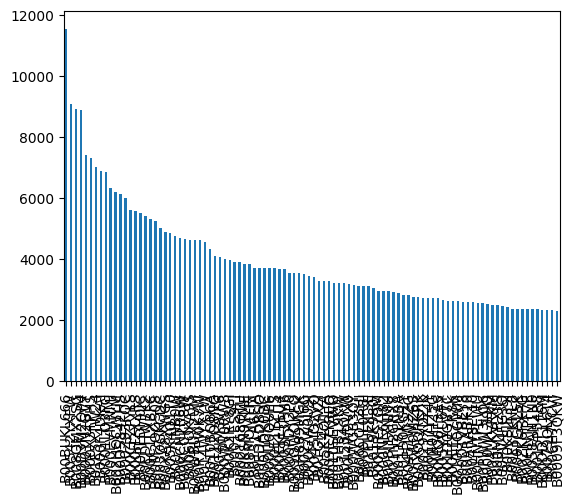

In [ ]:
# item rating count distribution follows an extremely long right tail
amazon_df['item_id'].value_counts()[:100].plot(kind='bar')

In [ ]:
amazon_df['item_id'].value_counts().describe()

count    283507.00000
mean         17.89783
std         107.50136
min           1.00000
25%           1.00000
50%           3.00000
75%           9.00000
max       11526.00000
Name: item_id, dtype: float64

In [ ]:
np.percentile(amazon_df['item_id'].value_counts(),99.9)

1273.9520000000484

<AxesSubplot:>

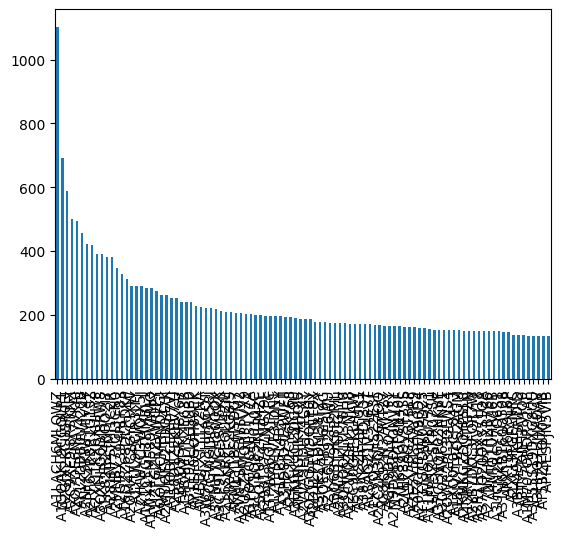

In [ ]:
# customer rating count distribution also follows an extremely long right tail
amazon_df['customer_id'].value_counts()[:100].plot(kind='bar')

In [ ]:
amazon_df['customer_id'].value_counts().describe()

count    2.695974e+06
mean     1.882125e+00
std      3.187802e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.103000e+03
Name: customer_id, dtype: float64

In [ ]:
np.percentile(amazon_df['customer_id'].value_counts(),99.99)

93.0

- Vast majority of items (75%) come with less than 10 ratings in total, and top 0.1% of items come with thousands of ratings. These could be top-selling products and/or products that are promoted with paid ratings.
- Vast majority of customers (75%) provide less than 2 ratings in total, and an extremely small proportion of customers (<0.001%) are associated with hundreds of ratings. These customers could be paid influencers for posting reviews for products.


In [ ]:
# overall rating value distributions
amazon_df['rating'].value_counts()

5.0    3573998
4.0     553201
1.0     405330
3.0     322134
2.0     219497
Name: rating, dtype: int64

In [ ]:
# rating value distributions for different percentile ranges
def rating_distributions(percentile_list, col):
    """
    function to create rating value distributions based on percentile range input
    
    input: - percentile_list is a list of percentile points defining range, i.e. [0,25,50,75,100]
           - col specifies column for running rating value distributions on
           
    output: dataframe with rating value distributions (count and rate) for different percentile ranges
    """
    c = len(percentile_list)
    df = pd.DataFrame([])
    
    for i in range(c-1):
        p1 = percentile_list[i]
        p2 = percentile_list[i + 1]
        item_list = col.value_counts()[
                    (col.value_counts() > np.percentile(col.value_counts(),p1))
                    & (col.value_counts() < np.percentile(col.value_counts(),p2))]
        item_list = item_list.index.to_list()
        s = amazon_df[col.isin(item_list)]['rating'].value_counts()
        s.name = f'{p1}-{p2}'
        df = df.append(s)
    
    df_norm = df.div(df.sum(axis=1), axis=0)
    return df, df_norm

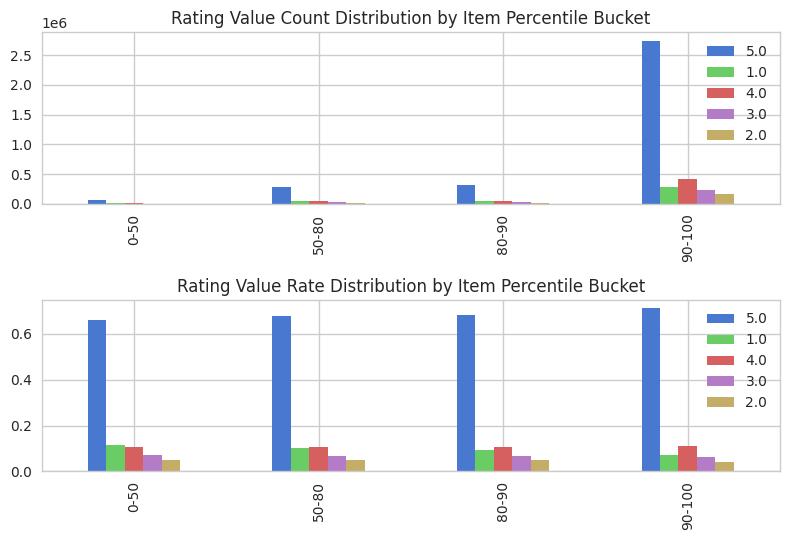

In [ ]:
# plot rating value distributions for item percentile ranges
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
# plt.figure(figsize=(12,3))

rating_distributions([0,50,80,90,100], col = amazon_df['item_id'])[0].plot(kind='bar',ax=ax1)
rating_distributions([0,50,80,90,100], col = amazon_df['item_id'])[1].plot(kind='bar',ax=ax2)

ax1.title.set_text('Rating Value Count Distribution by Item Percentile Bucket')
ax2.title.set_text('Rating Value Rate Distribution by Item Percentile Bucket')

plt.tight_layout()

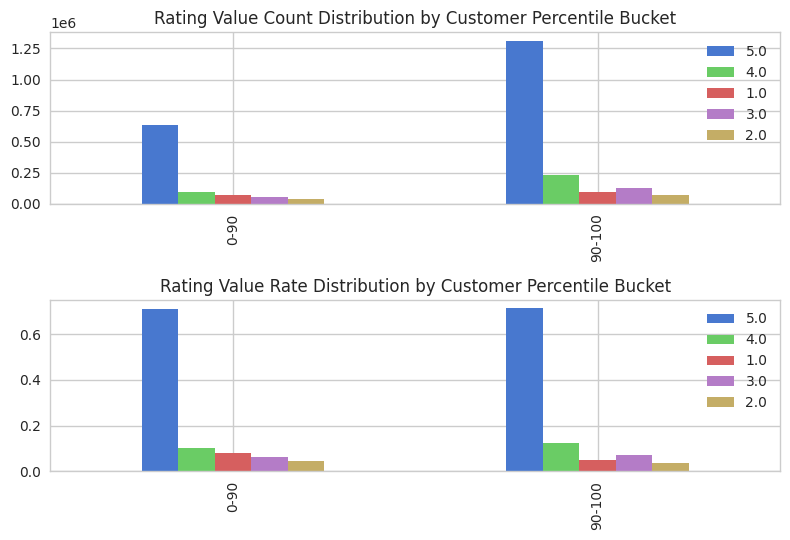

In [ ]:
# rating value distributions for customer percentile ranges
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
# plt.figure(figsize=(12,3))

rating_distributions([0,90,100], col = amazon_df['customer_id'])[0].plot(kind='bar',ax=ax1)
rating_distributions([0,90,100], col = amazon_df['customer_id'])[1].plot(kind='bar',ax=ax2)

ax1.title.set_text('Rating Value Count Distribution by Customer Percentile Bucket')
ax2.title.set_text('Rating Value Rate Distribution by Customer Percentile Bucket')

plt.tight_layout()

We now have an understanding of rating distributions from original dataset:
- there are a few extreme items that come with extremely high count of ratings and a few extreme customers that are giving out extremely high count of ratings.
- item rating value distributions are similar across percentile buckets 

#### Step 2: Select item_id and customer_id for mock dataset
- Select 24 reasonable items and an appropriate sample of customer_id to create mock dataset for Meet Fresh ingredient ratings

In [ ]:
# import random
# random.seed(10)

# items = amazon_df['item_id'].value_counts()[
#     (amazon_df['item_id'].value_counts() > np.percentile(amazon_df['item_id'].value_counts(),99.9))
#     # & (amazon_df['item_id'].value_counts() > np.percentile(amazon_df['item_id'].value_counts(),50))
#     ]
# items = items.index.to_list()

# mf_items = random.sample(items, 24)
# mf_ratings = amazon_df[amazon_df['item_id'].isin(mf_items)]

In [ ]:
# # adjust rating scale 1-5 to Meet Fresh rating scale 0-3
# rating_map = {1:0,2:0,3:1,4:2,5:3}
# mf_ratings['meetfresh_rating'] = mf_ratings['rating'].map(rating_map)
# mf_ratings

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,item_id,customer_id,rating,unix_review_time,meetfresh_rating
214240,B000EDDS6Q,A3R6PI47EF3F83,5.0,1165190400,3
214241,B000EDDS6Q,A1PJVPWL84EKH,5.0,1164758400,3
214242,B000EDDS6Q,A3HPZ6BIMNXSZR,5.0,1164585600,3
214243,B000EDDS6Q,A2DVBDD89B9WUU,5.0,1163030400,3
214244,B000EDDS6Q,A1ADHA5P7P7Q8N,5.0,1162512000,3
...,...,...,...,...,...
5049292,B01F2PYV20,A25WH4H0Q1SMTF,1.0,1537142400,0
5049293,B01F2PYV20,A37WWX1H709VVO,2.0,1537056000,0
5049294,B01F2PYV20,A232HRSC5R8ZDM,1.0,1536883200,0
5049295,B01F2PYV20,ARA5EH38LNJ4E,4.0,1536710400,2


#### Movies rating data

In [ ]:
import pandas as pd
from google.cloud import storage
from io import BytesIO

client = storage.Client()
bucket_name = "meet-fresh-recommendation-system-data"
file_name = "ratings.csv"
bucket = client.get_bucket(bucket_name)
blob = bucket.get_blob(file_name)
content = blob.download_as_string()
movies_df = pd.read_csv(BytesIO(content), header=0)

In [ ]:
movies_df = movies_df.rename(columns = {'movieId':'item_id','userId':'customer_id'})
movies_df.head()

,customer_id,item_id,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


<AxesSubplot:xlabel='rating'>

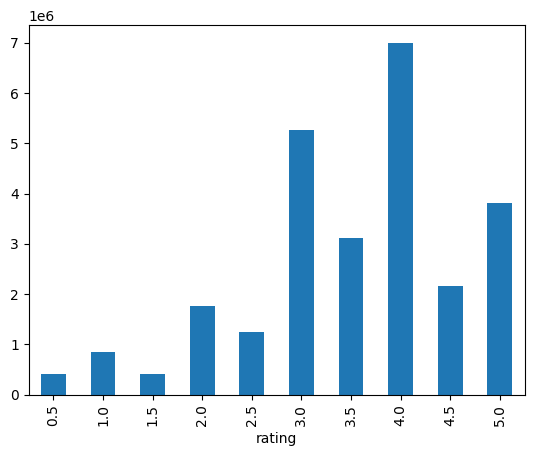

In [ ]:
# original rating distributions
movies_df.groupby(['rating'])['item_id'].count().plot(kind='bar')

In [ ]:
# group ratings to adapt to Meet Fresh rating scale
rating_map = {3:1,3.5:1,4:2,4.5:2,5:3}
movies_df['meetfresh_rating'] = movies_df['rating'].map(rating_map)
movies_df['meetfresh_rating'].value_counts(dropna=False)

2.0    9169243
1.0    8372935
NaN    4669612
3.0    3812499
Name: meetfresh_rating, dtype: int64

#### Step 1: Scoping original dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# scoping counts and average counts
review_cnt = len(movies_df)
item_cnt = movies_df['item_id'].nunique()
customer_cnt = movies_df['customer_id'].nunique()
review_per_item = review_cnt/item_cnt
review_per_customer = review_cnt/customer_cnt

print(f"Total ratings count: {review_cnt}")
print(f"Total items count: {item_cnt}")
print(f"Total customers count: {customer_cnt}")
print(f"Average rating count per item: {review_per_item:.2f}")
print(f"Average rating count per customer: {review_per_customer:.2f}")

Total ratings count: 26024289
Total items count: 45115
Total customers count: 270896
Average rating count per item: 576.84
Average rating count per customer: 96.07


In [ ]:
# quick summary of movies and users ratings distributions
movies_df['item_id'].value_counts().describe()

count    45115.000000
mean       576.843378
std       3037.380582
min          1.000000
25%          2.000000
50%          8.000000
75%         69.000000
max      91921.000000
Name: item_id, dtype: float64

In [ ]:
movies_df['customer_id'].value_counts().describe()

count    270896.000000
mean         96.067454
std         205.719606
min           1.000000
25%          15.000000
50%          30.000000
75%          93.000000
max       18276.000000
Name: customer_id, dtype: float64

In [ ]:
# rating value distributions for different percentile ranges
def rating_distributions(percentile_list, col):
    """
    function to create rating value distributions based on percentile range input
    
    input: - percentile_list is a list of percentile points defining range, i.e. [0,25,50,75,100]
           - col specifies column for running rating value distributions on
           
    output: dataframe with rating value distributions (count and rate) for different percentile ranges
    """
    c = len(percentile_list)
    df = pd.DataFrame([])
    
    for i in range(c-1):
        p1 = percentile_list[i]
        p2 = percentile_list[i + 1]
        item_list = col.value_counts()[
                    (col.value_counts() > np.percentile(col.value_counts(),p1))
                    & (col.value_counts() < np.percentile(col.value_counts(),p2))]
        item_list = item_list.index.to_list()
        s = movies_df[col.isin(item_list)]['meetfresh_rating'].value_counts()
        s.name = f'{p1}-{p2}'
        df = df.append(s)
    
    df_norm = df.div(df.sum(axis=1), axis=0)
    return df, df_norm

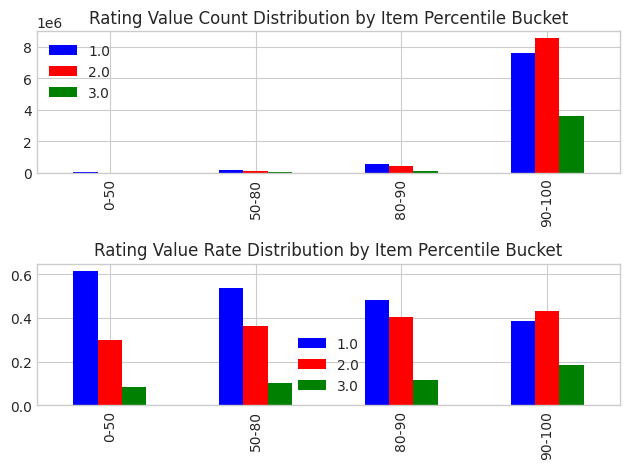

In [ ]:
# plot rating value distributions for item percentile ranges
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
# plt.figure(figsize=(12,3))

rating_distributions([0,50,80,90,100], col = movies_df['item_id'])[0].plot(kind='bar',ax=ax1, color=['blue', 'red', 'green'])
rating_distributions([0,50,80,90,100], col = movies_df['item_id'])[1].plot(kind='bar',ax=ax2, color=['blue', 'red', 'green'])

ax1.title.set_text('Rating Value Count Distribution by Item Percentile Bucket')
ax2.title.set_text('Rating Value Rate Distribution by Item Percentile Bucket')



plt.tight_layout()

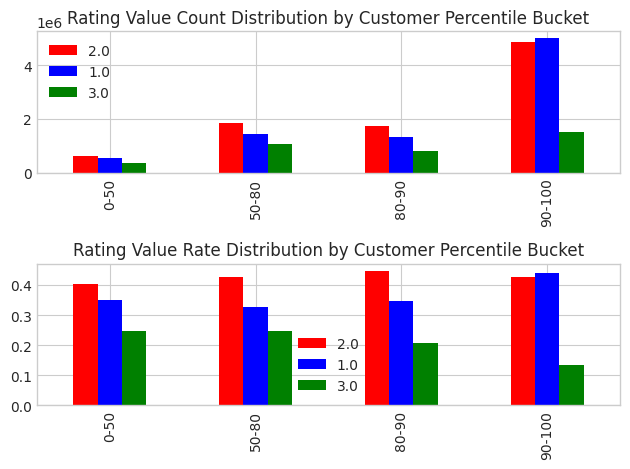

In [ ]:
# rating value distributions for customer percentile ranges
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
# plt.figure(figsize=(12,3))

rating_distributions([0,50,80,90,100], col = movies_df['customer_id'])[0].plot(kind='bar',ax=ax1, color=['red', 'blue', 'green'])
rating_distributions([0,50,80,90,100], col = movies_df['customer_id'])[1].plot(kind='bar',ax=ax2, color=['red', 'blue', 'green'])

ax1.title.set_text('Rating Value Count Distribution by Customer Percentile Bucket')
ax2.title.set_text('Rating Value Rate Distribution by Customer Percentile Bucket')

plt.tight_layout()

#### Step 2: Select item_id and customer_id for mock dataset
- Exclude ratings below 3.0 as they do not align with Meet Fresh rating scale 
- Stratified sampling for 24 items based on sales quantity distribution of Meet Fresh ingredients
- Sample customer_id to create mock dataset for Meet Fresh ingredient ratings

In [ ]:
# drop rows with meetfresh_rating = nan because we do not need them for Meet Fresh mock data
ratings_df = movies_df.dropna()
ratings_df['meetfresh_rating'].value_counts(dropna=False)

2.0    9169243
1.0    8372935
3.0    3812499
Name: meetfresh_rating, dtype: int64

In [ ]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21354677 entries, 1 to 26024287
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   customer_id       int64  
 1   item_id           int64  
 2   rating            float64
 3   timestamp         int64  
 4   meetfresh_rating  float64
dtypes: float64(2), int64(3)
memory usage: 977.5 MB


In [ ]:
%%bigquery quantity_df
SELECT * FROM `dsxl-ai-advanced-program.meetfresh.ft_agg_ingredient_sales_quantity_distribution`

Query is running:   0%|          |

Downloading:   0%|          |

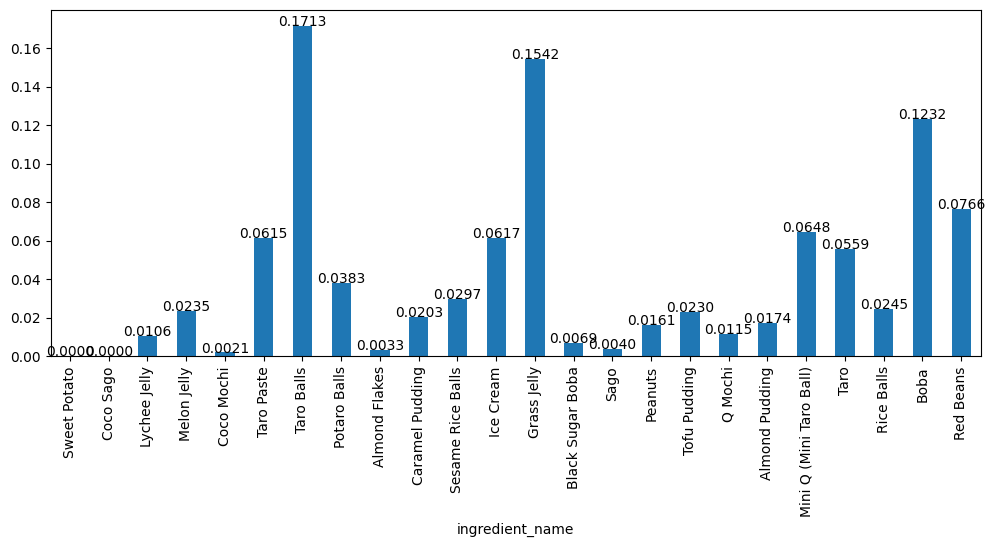

In [ ]:
# check out distributions for 24 ingredients
quantity_df['total_quantity_rate'] = quantity_df['grand_total_quantity']/np.sum(quantity_df['grand_total_quantity'], axis=0)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], f'{y[i]:.4f}', ha = 'center')
        

plt.figure(figsize = (12,4.5))
quantity_df.set_index('ingredient_name')['total_quantity_rate'].plot(kind='bar')
addlabels(quantity_df.index, quantity_df['total_quantity_rate'])

In [ ]:
# for each ingredient, use total_quantity_rate as mean and some randomness to conduct sampling
# and calculate average of rates
d = quantity_df.set_index('ingredient_name')['total_quantity_rate'].to_dict()
d_sample = {}

for k,v in d.items():
    mu, sigma = v, v/5 # mean and standard deviation
    s = np.random.normal(mu, sigma, 1000000)
    d_sample[k] = np.mean(s)

d_sample

{'Sweet Potato': 0.0,
 'Coco Sago': 0.0,
 'Lychee Jelly': 0.010554196078896148,
 'Melon Jelly': 0.023492469124856787,
 'Coco Mochi': 0.002058812894039008,
 'Taro Paste': 0.061458691391544674,
 'Taro Balls': 0.1713051035506637,
 'Potaro Balls': 0.03828090892069844,
 'Almond Flakes': 0.0032703266133312743,
 'Caramel Pudding': 0.020335571674225013,
 'Sesame Rice Balls': 0.029668684343881386,
 'Ice Cream': 0.06165306739996162,
 'Grass Jelly': 0.15411424853145297,
 'Black Sugar Boba': 0.006869937753147138,
 'Sago': 0.004028053524410879,
 'Peanuts': 0.016111757612053988,
 'Tofu Pudding': 0.022978333030490208,
 'Q Mochi': 0.011497139246596762,
 'Almond Pudding': 0.01736704583743372,
 'Mini Q (Mini Taro Ball)': 0.06481148079176993,
 'Taro': 0.05591642925341895,
 'Rice Balls': 0.024453407634065255,
 'Boba': 0.1232077467355945,
 'Red Beans': 0.07660182301770398}

In [ ]:
# stratified sampling without replacement from ratings_df (21354677 ratings) for each ingredient with sample size calculated for each
keys = list(d_sample.keys())
values = list(d_sample.values())
sorted_value_index = np.argsort(values)[::-1]
sorted_d_sample = {keys[i]: values[i] for i in sorted_value_index}
sorted_d_sample

{'Taro Balls': 0.1713051035506637,
 'Grass Jelly': 0.15411424853145297,
 'Boba': 0.1232077467355945,
 'Red Beans': 0.07660182301770398,
 'Mini Q (Mini Taro Ball)': 0.06481148079176993,
 'Ice Cream': 0.06165306739996162,
 'Taro Paste': 0.061458691391544674,
 'Taro': 0.05591642925341895,
 'Potaro Balls': 0.03828090892069844,
 'Sesame Rice Balls': 0.029668684343881386,
 'Rice Balls': 0.024453407634065255,
 'Melon Jelly': 0.023492469124856787,
 'Tofu Pudding': 0.022978333030490208,
 'Caramel Pudding': 0.020335571674225013,
 'Almond Pudding': 0.01736704583743372,
 'Peanuts': 0.016111757612053988,
 'Q Mochi': 0.011497139246596762,
 'Lychee Jelly': 0.010554196078896148,
 'Black Sugar Boba': 0.006869937753147138,
 'Sago': 0.004028053524410879,
 'Almond Flakes': 0.0032703266133312743,
 'Coco Mochi': 0.002058812894039008,
 'Coco Sago': 0.0,
 'Sweet Potato': 0.0}

In [ ]:
ratings_df['item_id'].value_counts().describe(percentiles = [0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.98,0.99,0.999,0.9999])

count     40799.000000
mean        523.411775
std        2812.205524
min           1.000000
40%           4.000000
50%           7.000000
60%          15.000000
70%          37.000000
80%         126.000000
90%         614.000000
95%        2044.100000
96%        2812.080000
97%        4214.240000
98%        6596.160000
99%       11370.660000
99.9%     37846.544000
99.99%    72336.082800
max       88563.000000
Name: item_id, dtype: float64

In [ ]:
# stratified sampling based on item percentile distribution
import math

N = 500000 # estimate number of yearly ratings
sample_sizes = {}
for key in sorted_d_sample:    
    sample_sizes[key] =  math.ceil(sorted_d_sample[key] * N)
sample_sizes

{'Taro Balls': 85653,
 'Grass Jelly': 77058,
 'Boba': 61604,
 'Red Beans': 38301,
 'Mini Q (Mini Taro Ball)': 32406,
 'Ice Cream': 30827,
 'Taro Paste': 30730,
 'Taro': 27959,
 'Potaro Balls': 19141,
 'Sesame Rice Balls': 14835,
 'Rice Balls': 12227,
 'Melon Jelly': 11747,
 'Tofu Pudding': 11490,
 'Caramel Pudding': 10168,
 'Almond Pudding': 8684,
 'Peanuts': 8056,
 'Q Mochi': 5749,
 'Lychee Jelly': 5278,
 'Black Sugar Boba': 3435,
 'Sago': 2015,
 'Almond Flakes': 1636,
 'Coco Mochi': 1030,
 'Coco Sago': 0,
 'Sweet Potato': 0}

In [ ]:
bins = [100, 99.99, 99.95, 99.9, 99, 98.9, 98.8, 98.7, 98, 97.8, 97.7, 97.6, 97.5, 97.4, 97, 96.5, 96, 95.5, 95, 94, 93, 92, 91, 90, 85]
ingredient_l = list(sample_sizes.keys())
c = len(bins)

mock_data_df = pd.DataFrame([])

for i in range(c-1):
        p1 = bins[i]
        p2 = bins[i + 1]
        item_list = ratings_df['item_id'].value_counts()[
                    (ratings_df['item_id'].value_counts() > np.percentile(ratings_df['item_id'].value_counts(),p2))
                    & (ratings_df['item_id'].value_counts() < np.percentile(ratings_df['item_id'].value_counts(),p1))]
        item_list = item_list.index.to_list()
        sample_df = ratings_df[ratings_df['item_id'].isin(item_list)].sample(n=sample_sizes[ingredient_l[i]], replace=False, random_state=1)
        sample_df['ingredient_name'] = ingredient_l[i]
        mock_data_df = mock_data_df.append(sample_df)

In [ ]:
# save this to GCS bucket for later
from google.cloud import storage
import os
import pandas as pd

client = storage.Client()
bucket = client.get_bucket('meet-fresh-recommendation-system-data')
    
bucket.blob('meetfresh_ratings_mock_data.csv').upload_from_string(mock_data_df.to_csv(), 'text/csv')

Last step is to map Meet Fresh ingredient id to ingredient names in mock data and check customer item distribution

In [ ]:
import pandas as pd
from google.cloud import storage
from io import BytesIO

client = storage.Client()
bucket_name = "meet-fresh-recommendation-system-data"
file_name = "meetfresh_ratings_mock_data.csv"
bucket = client.get_bucket(bucket_name)
blob = bucket.get_blob(file_name)
content = blob.download_as_string()
mock_data_df = pd.read_csv(BytesIO(content), header=0, usecols=range(1,7))

In [ ]:
%%bigquery quantity_df
SELECT * FROM `dsxl-ai-advanced-program.meetfresh.ft_agg_ingredient_sales_quantity_distribution`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# overwrite item_id to map to Meet Fresh ingredient_id
ingredient_map = quantity_df.set_index('ingredient_name')['ingredient_id'].to_dict()
mock_data_df['ingredient_id'] = mock_data_df['ingredient_name'].map(ingredient_map)
mock_data_df.drop(['item_id','timestamp','rating'], axis=1, inplace=True)
col_order = ['customer_id','ingredient_id','ingredient_name','meetfresh_rating']
mock_data_df = mock_data_df[col_order]
mock_data_df

,customer_id,ingredient_id,ingredient_name,meetfresh_rating
0,70338,TP108,Taro Balls,2.0
1,66367,TP108,Taro Balls,1.0
2,136813,TP108,Taro Balls,2.0
3,86557,TP108,Taro Balls,3.0
4,151253,TP108,Taro Balls,3.0
...,...,...,...,...
500024,213081,TP116,Coco Mochi,1.0
500025,164136,TP116,Coco Mochi,2.0
500026,222748,TP116,Coco Mochi,1.0
500027,142663,TP116,Coco Mochi,1.0


In [ ]:
# check distribution again to see if it makes sense
mock_data_df.groupby('customer_id')['ingredient_id'].nunique().describe()

count    155594.000000
mean          2.640256
std           2.228229
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          21.000000
Name: ingredient_id, dtype: float64

Matching our hypothesis that customer ingredient distribution should be skewed towards less than 5 items

In [ ]:
# save this to GCS bucket for later
from google.cloud import storage
import os
import pandas as pd

client = storage.Client()
bucket = client.get_bucket('meet-fresh-recommendation-system-data')
    
bucket.blob('meetfresh_ratings_mock_data_final.csv').upload_from_string(mock_data_df.to_csv(index=False), 'text/csv')

### Creating mock data for Meet Fresh customer-level ratings of ingredients
- [Amazon review data source](https://nijianmo.github.io/amazon/index.html#sample-review)
- [Movies rating data source](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=ratings.csv)


For building a recsys POC, customer-level rating data is one of the primary data sources needed. We explore two alternative data sources for creating mock data and select the most suitable. Mock data is then created so that it's adapted to Meet Fresh ingredient items.

In [ ]:
import pandas as pd
from google.cloud import storage
from io import BytesIO

client = storage.Client()
bucket_name = "meet-fresh-recommendation-system-data"
file_name = "Grocery_and_Gourmet_Food.csv"
bucket = client.get_bucket(bucket_name)
blob = bucket.get_blob(file_name)
content = blob.download_as_string()
amazon_df = pd.read_csv(BytesIO(content), header=None)

In [ ]:
amazon_df = amazon_df.rename(columns = {0:'item_id',1:'customer_id',2:'rating',3:'unix_review_time'})
amazon_df.head(10)

,item_id,customer_id,rating,unix_review_time
0,1888861614,ALP49FBWT4I7V,5.0,1370304000
1,1888861614,A1KPIZOCLB9FZ8,4.0,1400803200
2,1888861614,A2W0FA06IYAYQE,4.0,1399593600
3,1888861614,A2PTZTCH2QUYBC,5.0,1397952000
4,1888861614,A2VNHGJ59N4Z90,4.0,1397606400
5,1888861614,ATQL0XOLZNHZ4,1.0,1392940800
6,1888861614,A94ZG5CWN70E7,5.0,1385856000
7,1888861614,A3QBT8YC3CZ7C9,3.0,1383696000
8,1888861614,AGKW3A1RB1YGO,5.0,1380672000
9,1888861614,A1B65IWLUVOUQB,5.0,1378425600


#### Step 1: Scoping original dataset
Scope total dataset size, number of items and customers, and rating distributions to understand how to best adapt data to Meet Fresh

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5074160 entries, 0 to 5074159
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           object 
 1   customer_id       object 
 2   rating            float64
 3   unix_review_time  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 154.9+ MB


In [ ]:
# scoping counts and average counts
review_cnt = len(amazon_df)
item_cnt = amazon_df['item_id'].nunique()
customer_cnt = amazon_df['customer_id'].nunique()
review_per_item = review_cnt/item_cnt
review_per_customer = review_cnt/customer_cnt

print(f"Total ratings count: {review_cnt}")
print(f"Total items count: {item_cnt}")
print(f"Total customers count: {customer_cnt}")
print(f"Average rating count per item: {review_per_item:.2f}")
print(f"Average rating count per customer: {review_per_customer:.2f}")

Total ratings count: 5074160
Total items count: 283507
Total customers count: 2695974
Average rating count per item: 17.90
Average rating count per customer: 1.88


<AxesSubplot:>

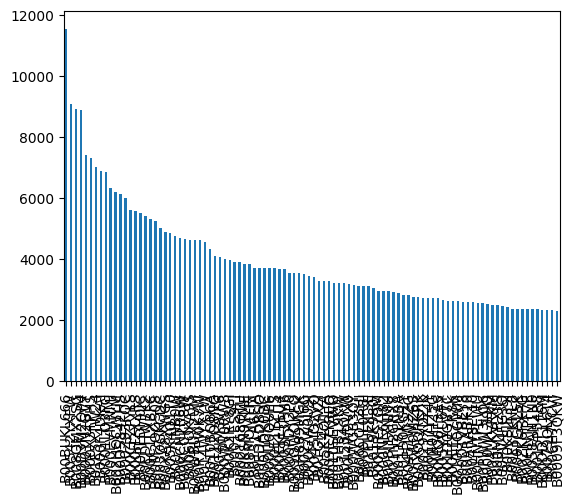

In [ ]:
# item rating count distribution follows an extremely long right tail
amazon_df['item_id'].value_counts()[:100].plot(kind='bar')

In [ ]:
amazon_df['item_id'].value_counts().describe()

count    283507.00000
mean         17.89783
std         107.50136
min           1.00000
25%           1.00000
50%           3.00000
75%           9.00000
max       11526.00000
Name: item_id, dtype: float64

In [ ]:
np.percentile(amazon_df['item_id'].value_counts(),99.9)

1273.9520000000484

<AxesSubplot:>

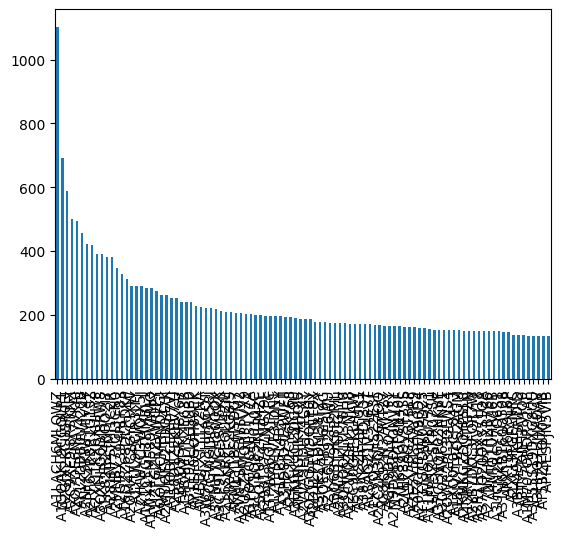

In [ ]:
# customer rating count distribution also follows an extremely long right tail
amazon_df['customer_id'].value_counts()[:100].plot(kind='bar')

In [ ]:
amazon_df['customer_id'].value_counts().describe()

count    2.695974e+06
mean     1.882125e+00
std      3.187802e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.103000e+03
Name: customer_id, dtype: float64

In [ ]:
np.percentile(amazon_df['customer_id'].value_counts(),99.99)

93.0

- Vast majority of items (75%) come with less than 10 ratings in total, and top 0.1% of items come with thousands of ratings. These could be top-selling products and/or products that are promoted with paid ratings.
- Vast majority of customers (75%) provide less than 2 ratings in total, and an extremely small proportion of customers (<0.001%) are associated with hundreds of ratings. These customers could be paid influencers for posting reviews for products.


In [ ]:
# overall rating value distributions
amazon_df['rating'].value_counts()

5.0    3573998
4.0     553201
1.0     405330
3.0     322134
2.0     219497
Name: rating, dtype: int64

In [ ]:
# rating value distributions for different percentile ranges
def rating_distributions(percentile_list, col):
    """
    function to create rating value distributions based on percentile range input
    
    input: - percentile_list is a list of percentile points defining range, i.e. [0,25,50,75,100]
           - col specifies column for running rating value distributions on
           
    output: dataframe with rating value distributions (count and rate) for different percentile ranges
    """
    c = len(percentile_list)
    df = pd.DataFrame([])
    
    for i in range(c-1):
        p1 = percentile_list[i]
        p2 = percentile_list[i + 1]
        item_list = col.value_counts()[
                    (col.value_counts() > np.percentile(col.value_counts(),p1))
                    & (col.value_counts() < np.percentile(col.value_counts(),p2))]
        item_list = item_list.index.to_list()
        s = amazon_df[col.isin(item_list)]['rating'].value_counts()
        s.name = f'{p1}-{p2}'
        df = df.append(s)
    
    df_norm = df.div(df.sum(axis=1), axis=0)
    return df, df_norm

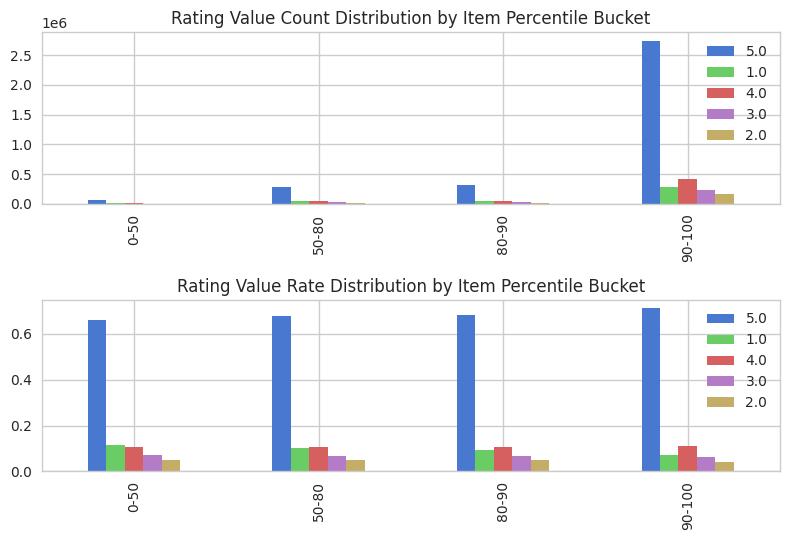

In [ ]:
# plot rating value distributions for item percentile ranges
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
# plt.figure(figsize=(12,3))

rating_distributions([0,50,80,90,100], col = amazon_df['item_id'])[0].plot(kind='bar',ax=ax1)
rating_distributions([0,50,80,90,100], col = amazon_df['item_id'])[1].plot(kind='bar',ax=ax2)

ax1.title.set_text('Rating Value Count Distribution by Item Percentile Bucket')
ax2.title.set_text('Rating Value Rate Distribution by Item Percentile Bucket')

plt.tight_layout()

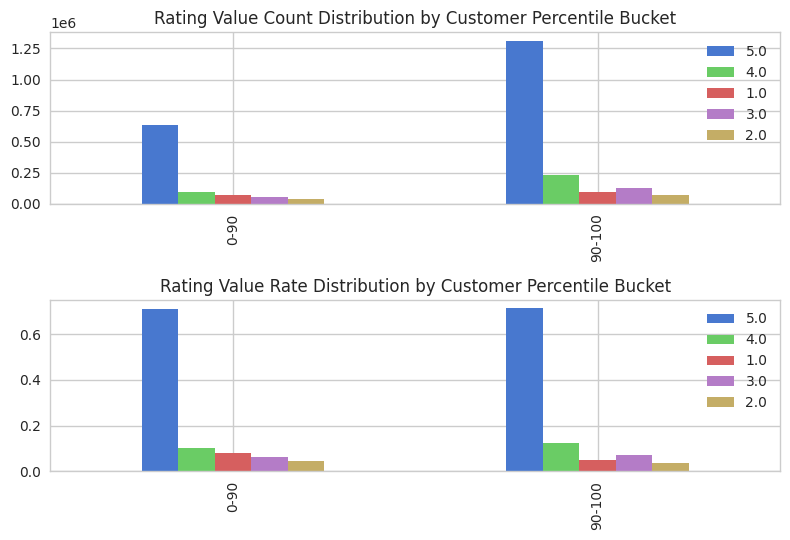

In [ ]:
# rating value distributions for customer percentile ranges
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
# plt.figure(figsize=(12,3))

rating_distributions([0,90,100], col = amazon_df['customer_id'])[0].plot(kind='bar',ax=ax1)
rating_distributions([0,90,100], col = amazon_df['customer_id'])[1].plot(kind='bar',ax=ax2)

ax1.title.set_text('Rating Value Count Distribution by Customer Percentile Bucket')
ax2.title.set_text('Rating Value Rate Distribution by Customer Percentile Bucket')

plt.tight_layout()

We now have an understanding of rating distributions from original dataset:
- there are a few extreme items that come with extremely high count of ratings and a few extreme customers that are giving out extremely high count of ratings.
- item rating value distributions are similar across percentile buckets 

#### Step 2: Select item_id and customer_id for mock dataset
- Select 24 reasonable items and an appropriate sample of customer_id to create mock dataset for Meet Fresh ingredient ratings

In [ ]:
# import random
# random.seed(10)

# items = amazon_df['item_id'].value_counts()[
#     (amazon_df['item_id'].value_counts() > np.percentile(amazon_df['item_id'].value_counts(),99.9))
#     # & (amazon_df['item_id'].value_counts() > np.percentile(amazon_df['item_id'].value_counts(),50))
#     ]
# items = items.index.to_list()

# mf_items = random.sample(items, 24)
# mf_ratings = amazon_df[amazon_df['item_id'].isin(mf_items)]

In [ ]:
# # adjust rating scale 1-5 to Meet Fresh rating scale 0-3
# rating_map = {1:0,2:0,3:1,4:2,5:3}
# mf_ratings['meetfresh_rating'] = mf_ratings['rating'].map(rating_map)
# mf_ratings

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,item_id,customer_id,rating,unix_review_time,meetfresh_rating
214240,B000EDDS6Q,A3R6PI47EF3F83,5.0,1165190400,3
214241,B000EDDS6Q,A1PJVPWL84EKH,5.0,1164758400,3
214242,B000EDDS6Q,A3HPZ6BIMNXSZR,5.0,1164585600,3
214243,B000EDDS6Q,A2DVBDD89B9WUU,5.0,1163030400,3
214244,B000EDDS6Q,A1ADHA5P7P7Q8N,5.0,1162512000,3
...,...,...,...,...,...
5049292,B01F2PYV20,A25WH4H0Q1SMTF,1.0,1537142400,0
5049293,B01F2PYV20,A37WWX1H709VVO,2.0,1537056000,0
5049294,B01F2PYV20,A232HRSC5R8ZDM,1.0,1536883200,0
5049295,B01F2PYV20,ARA5EH38LNJ4E,4.0,1536710400,2


In [ ]:
mf_ratings['meetfresh_rating'].value_counts()

3    41756
0     7610
2     6653
1     3658
Name: meetfresh_rating, dtype: int64

In [ ]:
%%bigquery dim_ingredient
SELECT * FROM `dsxl-ai-advanced-program.meetfresh.dim_ingredient`

Executing query with job ID: f90d344d-8bd4-4f9d-9cb0-227f92cb4d2d
Query executing: 0.26s


ERROR:
 404 Not found: Table dsxl-ai-advanced-program:meetfresh.dim_ingredient was not found in location US

Location: US
Job ID: f90d344d-8bd4-4f9d-9cb0-227f92cb4d2d



### Creating mock data for Meet Fresh customer-level ratings of ingredients
- [Amazon review data source](https://nijianmo.github.io/amazon/index.html#sample-review)
- [Movies rating data source](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=ratings.csv)


For building a recsys POC, customer-level rating data is one of the primary data sources needed. Mock data is created based on external rating data, which is adapted to Meet Fresh ingredient items.

#### Amazon review data

In [ ]:
import pandas as pd
from google.cloud import storage
from io import BytesIO

client = storage.Client()
bucket_name = "meet-fresh-recommendation-system-data"
file_name = "Grocery_and_Gourmet_Food.csv"
bucket = client.get_bucket(bucket_name)
blob = bucket.get_blob(file_name)
content = blob.download_as_string()
amazon_df = pd.read_csv(BytesIO(content), header=None)

In [ ]:
amazon_df = amazon_df.rename(columns = {0:'item_id',1:'customer_id',2:'rating',3:'unix_review_time'})
amazon_df.head(10)

,item_id,customer_id,rating,unix_review_time
0,1888861614,ALP49FBWT4I7V,5.0,1370304000
1,1888861614,A1KPIZOCLB9FZ8,4.0,1400803200
2,1888861614,A2W0FA06IYAYQE,4.0,1399593600
3,1888861614,A2PTZTCH2QUYBC,5.0,1397952000
4,1888861614,A2VNHGJ59N4Z90,4.0,1397606400
5,1888861614,ATQL0XOLZNHZ4,1.0,1392940800
6,1888861614,A94ZG5CWN70E7,5.0,1385856000
7,1888861614,A3QBT8YC3CZ7C9,3.0,1383696000
8,1888861614,AGKW3A1RB1YGO,5.0,1380672000
9,1888861614,A1B65IWLUVOUQB,5.0,1378425600


#### Step 1: Scoping original dataset
Scope total dataset size, number of items and customers, and rating distributions to understand how to best adapt data to Meet Fresh

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5074160 entries, 0 to 5074159
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           object 
 1   customer_id       object 
 2   rating            float64
 3   unix_review_time  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 154.9+ MB


In [ ]:
# scoping counts and average counts
review_cnt = len(amazon_df)
item_cnt = amazon_df['item_id'].nunique()
customer_cnt = amazon_df['customer_id'].nunique()
review_per_item = review_cnt/item_cnt
review_per_customer = review_cnt/customer_cnt

print(f"Total ratings count: {review_cnt}")
print(f"Total items count: {item_cnt}")
print(f"Total customers count: {customer_cnt}")
print(f"Average rating count per item: {review_per_item:.2f}")
print(f"Average rating count per customer: {review_per_customer:.2f}")

Total ratings count: 5074160
Total items count: 283507
Total customers count: 2695974
Average rating count per item: 17.90
Average rating count per customer: 1.88


<AxesSubplot:>

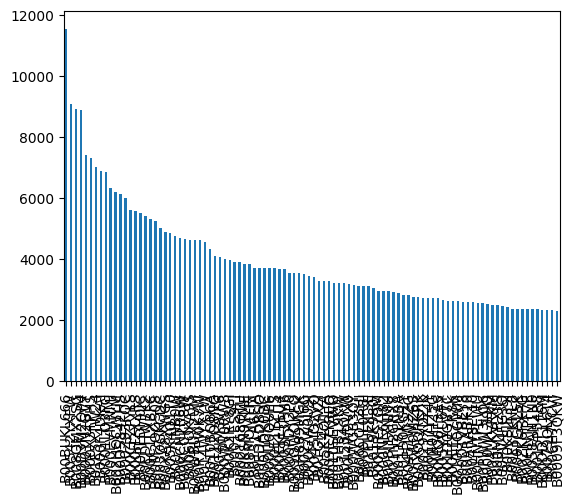

In [ ]:
# item rating count distribution follows an extremely long right tail
amazon_df['item_id'].value_counts()[:100].plot(kind='bar')

In [ ]:
amazon_df['item_id'].value_counts().describe()

count    283507.00000
mean         17.89783
std         107.50136
min           1.00000
25%           1.00000
50%           3.00000
75%           9.00000
max       11526.00000
Name: item_id, dtype: float64

In [ ]:
np.percentile(amazon_df['item_id'].value_counts(),99.9)

1273.9520000000484

<AxesSubplot:>

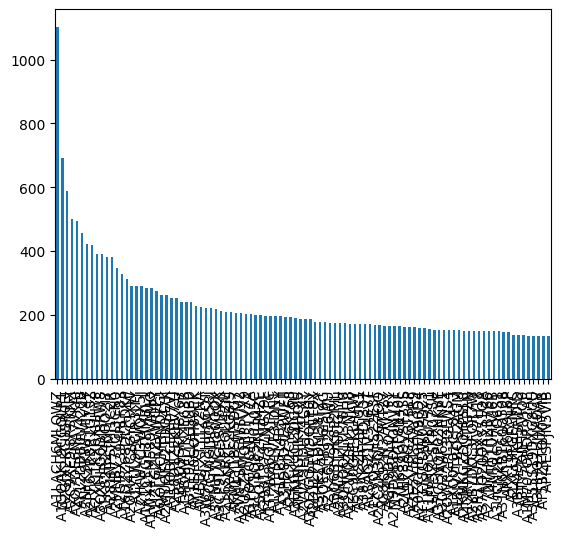

In [ ]:
# customer rating count distribution also follows an extremely long right tail
amazon_df['customer_id'].value_counts()[:100].plot(kind='bar')

In [ ]:
amazon_df['customer_id'].value_counts().describe()

count    2.695974e+06
mean     1.882125e+00
std      3.187802e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.103000e+03
Name: customer_id, dtype: float64

In [ ]:
np.percentile(amazon_df['customer_id'].value_counts(),99.99)

93.0

- Vast majority of items (75%) come with less than 10 ratings in total, and top 0.1% of items come with thousands of ratings. These could be top-selling products and/or products that are promoted with paid ratings.
- Vast majority of customers (75%) provide less than 2 ratings in total, and an extremely small proportion of customers (<0.001%) are associated with hundreds of ratings. These customers could be paid influencers for posting reviews for products.


In [ ]:
# overall rating value distributions
amazon_df['rating'].value_counts()

5.0    3573998
4.0     553201
1.0     405330
3.0     322134
2.0     219497
Name: rating, dtype: int64

In [ ]:
# rating value distributions for different percentile ranges
def rating_distributions(percentile_list, col):
    """
    function to create rating value distributions based on percentile range input
    
    input: - percentile_list is a list of percentile points defining range, i.e. [0,25,50,75,100]
           - col specifies column for running rating value distributions on
           
    output: dataframe with rating value distributions (count and rate) for different percentile ranges
    """
    c = len(percentile_list)
    df = pd.DataFrame([])
    
    for i in range(c-1):
        p1 = percentile_list[i]
        p2 = percentile_list[i + 1]
        item_list = col.value_counts()[
                    (col.value_counts() > np.percentile(col.value_counts(),p1))
                    & (col.value_counts() < np.percentile(col.value_counts(),p2))]
        item_list = item_list.index.to_list()
        s = amazon_df[col.isin(item_list)]['rating'].value_counts()
        s.name = f'{p1}-{p2}'
        df = df.append(s)
    
    df_norm = df.div(df.sum(axis=1), axis=0)
    return df, df_norm

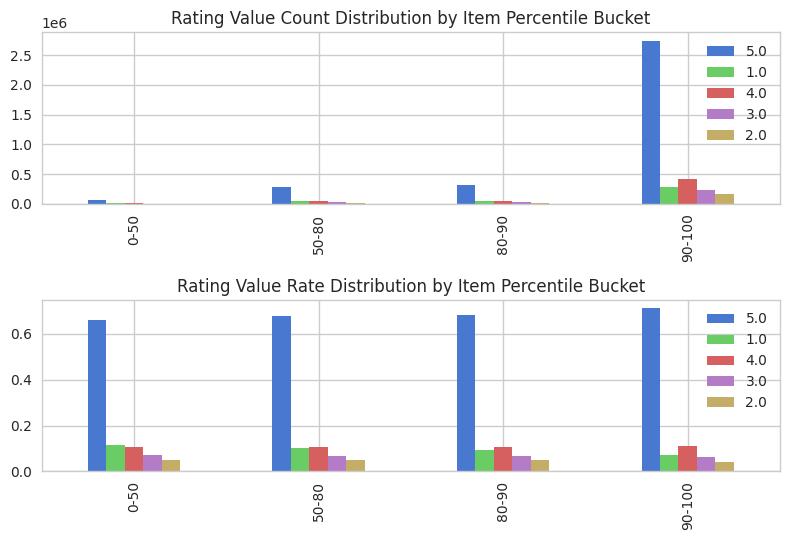

In [ ]:
# plot rating value distributions for item percentile ranges
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
# plt.figure(figsize=(12,3))

rating_distributions([0,50,80,90,100], col = amazon_df['item_id'])[0].plot(kind='bar',ax=ax1)
rating_distributions([0,50,80,90,100], col = amazon_df['item_id'])[1].plot(kind='bar',ax=ax2)

ax1.title.set_text('Rating Value Count Distribution by Item Percentile Bucket')
ax2.title.set_text('Rating Value Rate Distribution by Item Percentile Bucket')

plt.tight_layout()

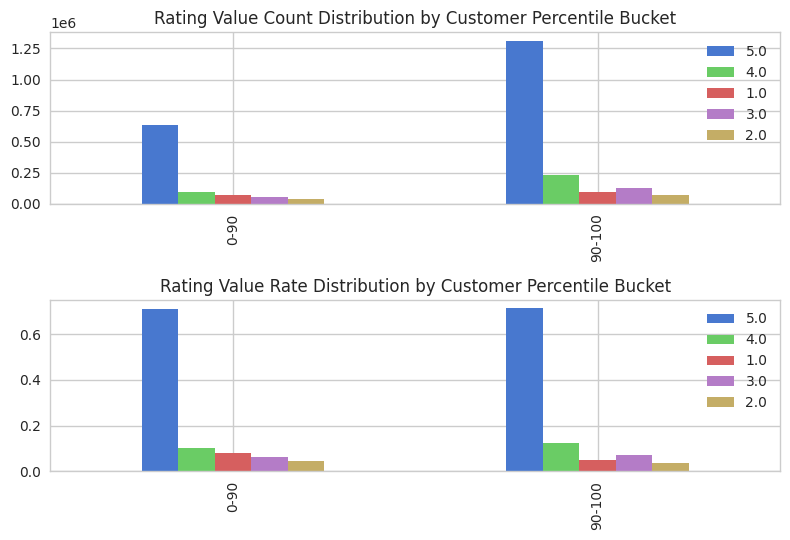

In [ ]:
# rating value distributions for customer percentile ranges
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
# plt.figure(figsize=(12,3))

rating_distributions([0,90,100], col = amazon_df['customer_id'])[0].plot(kind='bar',ax=ax1)
rating_distributions([0,90,100], col = amazon_df['customer_id'])[1].plot(kind='bar',ax=ax2)

ax1.title.set_text('Rating Value Count Distribution by Customer Percentile Bucket')
ax2.title.set_text('Rating Value Rate Distribution by Customer Percentile Bucket')

plt.tight_layout()

We now have an understanding of rating distributions from original dataset:
- there are a few extreme items that come with extremely high count of ratings and a few extreme customers that are giving out extremely high count of ratings.
- item rating value distributions are similar across percentile buckets 

#### Step 2: Select item_id and customer_id for mock dataset
- Select 24 reasonable items and an appropriate sample of customer_id to create mock dataset for Meet Fresh ingredient ratings

In [ ]:
# import random
# random.seed(10)

# items = amazon_df['item_id'].value_counts()[
#     (amazon_df['item_id'].value_counts() > np.percentile(amazon_df['item_id'].value_counts(),99.9))
#     # & (amazon_df['item_id'].value_counts() > np.percentile(amazon_df['item_id'].value_counts(),50))
#     ]
# items = items.index.to_list()

# mf_items = random.sample(items, 24)
# mf_ratings = amazon_df[amazon_df['item_id'].isin(mf_items)]

In [ ]:
# # adjust rating scale 1-5 to Meet Fresh rating scale 0-3
# rating_map = {1:0,2:0,3:1,4:2,5:3}
# mf_ratings['meetfresh_rating'] = mf_ratings['rating'].map(rating_map)
# mf_ratings

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,item_id,customer_id,rating,unix_review_time,meetfresh_rating
214240,B000EDDS6Q,A3R6PI47EF3F83,5.0,1165190400,3
214241,B000EDDS6Q,A1PJVPWL84EKH,5.0,1164758400,3
214242,B000EDDS6Q,A3HPZ6BIMNXSZR,5.0,1164585600,3
214243,B000EDDS6Q,A2DVBDD89B9WUU,5.0,1163030400,3
214244,B000EDDS6Q,A1ADHA5P7P7Q8N,5.0,1162512000,3
...,...,...,...,...,...
5049292,B01F2PYV20,A25WH4H0Q1SMTF,1.0,1537142400,0
5049293,B01F2PYV20,A37WWX1H709VVO,2.0,1537056000,0
5049294,B01F2PYV20,A232HRSC5R8ZDM,1.0,1536883200,0
5049295,B01F2PYV20,ARA5EH38LNJ4E,4.0,1536710400,2


#### Movies rating data

In [ ]:
import pandas as pd
from google.cloud import storage
from io import BytesIO

client = storage.Client()
bucket_name = "meet-fresh-recommendation-system-data"
file_name = "ratings.csv"
bucket = client.get_bucket(bucket_name)
blob = bucket.get_blob(file_name)
content = blob.download_as_string()
movies_df = pd.read_csv(BytesIO(content), header=0)

In [ ]:
movies_df = movies_df.rename(columns = {'movieId':'item_id','userId':'customer_id'})
movies_df.head()

,customer_id,item_id,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


<AxesSubplot:xlabel='rating'>

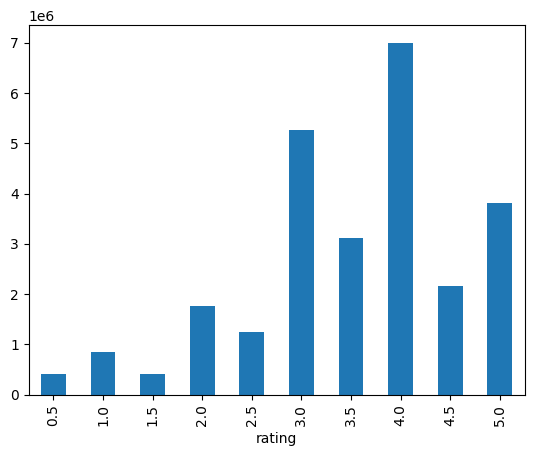

In [ ]:
# original rating distributions
movies_df.groupby(['rating'])['item_id'].count().plot(kind='bar')

In [ ]:
# group ratings to adapt to Meet Fresh rating scale
rating_map = {3:1,3.5:1,4:2,4.5:2,5:3}
movies_df['meetfresh_rating'] = movies_df['rating'].map(rating_map)
movies_df['meetfresh_rating'].value_counts(dropna=False)

2.0    9169243
1.0    8372935
NaN    4669612
3.0    3812499
Name: meetfresh_rating, dtype: int64

#### Step 1: Scoping original dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# scoping counts and average counts
review_cnt = len(movies_df)
item_cnt = movies_df['item_id'].nunique()
customer_cnt = movies_df['customer_id'].nunique()
review_per_item = review_cnt/item_cnt
review_per_customer = review_cnt/customer_cnt

print(f"Total ratings count: {review_cnt}")
print(f"Total items count: {item_cnt}")
print(f"Total customers count: {customer_cnt}")
print(f"Average rating count per item: {review_per_item:.2f}")
print(f"Average rating count per customer: {review_per_customer:.2f}")

Total ratings count: 26024289
Total items count: 45115
Total customers count: 270896
Average rating count per item: 576.84
Average rating count per customer: 96.07


In [ ]:
# quick summary of movies and users ratings distributions
movies_df['item_id'].value_counts().describe()

count    45115.000000
mean       576.843378
std       3037.380582
min          1.000000
25%          2.000000
50%          8.000000
75%         69.000000
max      91921.000000
Name: item_id, dtype: float64

In [ ]:
movies_df['customer_id'].value_counts().describe()

count    270896.000000
mean         96.067454
std         205.719606
min           1.000000
25%          15.000000
50%          30.000000
75%          93.000000
max       18276.000000
Name: customer_id, dtype: float64

In [ ]:
# rating value distributions for different percentile ranges
def rating_distributions(percentile_list, col):
    """
    function to create rating value distributions based on percentile range input
    
    input: - percentile_list is a list of percentile points defining range, i.e. [0,25,50,75,100]
           - col specifies column for running rating value distributions on
           
    output: dataframe with rating value distributions (count and rate) for different percentile ranges
    """
    c = len(percentile_list)
    df = pd.DataFrame([])
    
    for i in range(c-1):
        p1 = percentile_list[i]
        p2 = percentile_list[i + 1]
        item_list = col.value_counts()[
                    (col.value_counts() > np.percentile(col.value_counts(),p1))
                    & (col.value_counts() < np.percentile(col.value_counts(),p2))]
        item_list = item_list.index.to_list()
        s = movies_df[col.isin(item_list)]['meetfresh_rating'].value_counts()
        s.name = f'{p1}-{p2}'
        df = df.append(s)
    
    df_norm = df.div(df.sum(axis=1), axis=0)
    return df, df_norm

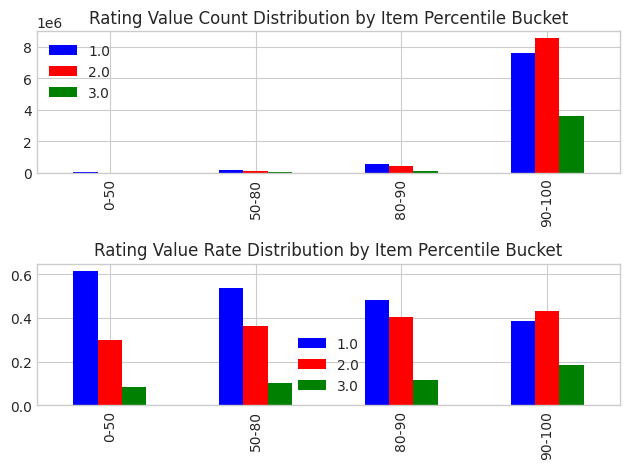

In [ ]:
# plot rating value distributions for item percentile ranges
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
# plt.figure(figsize=(12,3))

rating_distributions([0,50,80,90,100], col = movies_df['item_id'])[0].plot(kind='bar',ax=ax1, color=['blue', 'red', 'green'])
rating_distributions([0,50,80,90,100], col = movies_df['item_id'])[1].plot(kind='bar',ax=ax2, color=['blue', 'red', 'green'])

ax1.title.set_text('Rating Value Count Distribution by Item Percentile Bucket')
ax2.title.set_text('Rating Value Rate Distribution by Item Percentile Bucket')



plt.tight_layout()

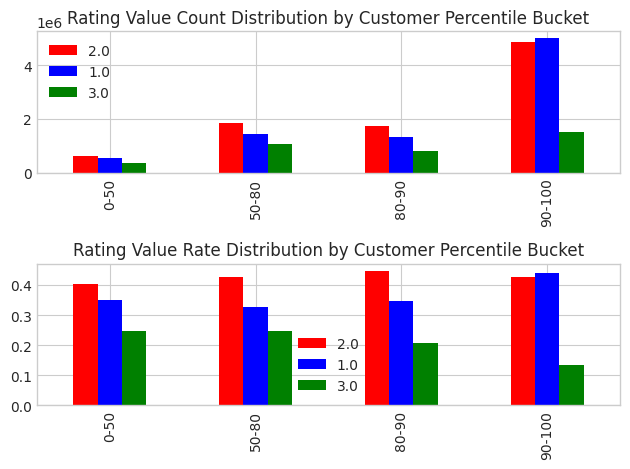

In [ ]:
# rating value distributions for customer percentile ranges
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
# plt.figure(figsize=(12,3))

rating_distributions([0,50,80,90,100], col = movies_df['customer_id'])[0].plot(kind='bar',ax=ax1, color=['red', 'blue', 'green'])
rating_distributions([0,50,80,90,100], col = movies_df['customer_id'])[1].plot(kind='bar',ax=ax2, color=['red', 'blue', 'green'])

ax1.title.set_text('Rating Value Count Distribution by Customer Percentile Bucket')
ax2.title.set_text('Rating Value Rate Distribution by Customer Percentile Bucket')

plt.tight_layout()

#### Step 2: Select item_id and customer_id for mock dataset
- Exclude ratings below 3.0 as they do not align with Meet Fresh rating scale 
- Stratified sampling for 24 items based on sales quantity distribution of Meet Fresh ingredients
- Sample customer_id to create mock dataset for Meet Fresh ingredient ratings

In [ ]:
# drop rows with meetfresh_rating = nan because we do not need them for Meet Fresh mock data
ratings_df = movies_df.dropna()
ratings_df['meetfresh_rating'].value_counts(dropna=False)

2.0    9169243
1.0    8372935
3.0    3812499
Name: meetfresh_rating, dtype: int64

In [ ]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21354677 entries, 1 to 26024287
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   customer_id       int64  
 1   item_id           int64  
 2   rating            float64
 3   timestamp         int64  
 4   meetfresh_rating  float64
dtypes: float64(2), int64(3)
memory usage: 977.5 MB


In [ ]:
%%bigquery quantity_df
SELECT * FROM `dsxl-ai-advanced-program.meetfresh.ft_agg_ingredient_sales_quantity_distribution`

Query is running:   0%|          |

Downloading:   0%|          |

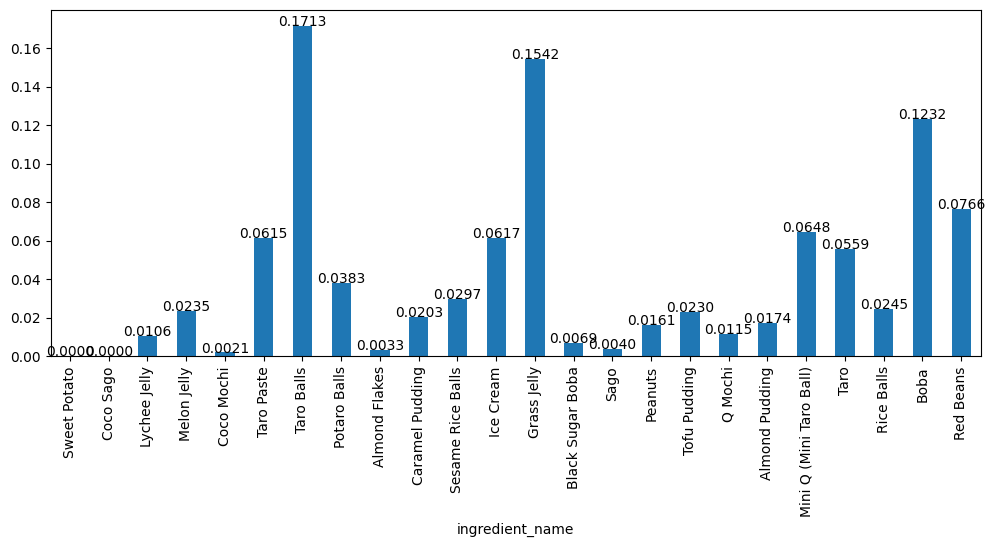

In [ ]:
# check out distributions for 24 ingredients
quantity_df['total_quantity_rate'] = quantity_df['grand_total_quantity']/np.sum(quantity_df['grand_total_quantity'], axis=0)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], f'{y[i]:.4f}', ha = 'center')
        

plt.figure(figsize = (12,4.5))
quantity_df.set_index('ingredient_name')['total_quantity_rate'].plot(kind='bar')
addlabels(quantity_df.index, quantity_df['total_quantity_rate'])

In [ ]:
# for each ingredient, use total_quantity_rate as mean and some randomness to conduct sampling
# and calculate average of rates
d = quantity_df.set_index('ingredient_name')['total_quantity_rate'].to_dict()
d_sample = {}

for k,v in d.items():
    mu, sigma = v, v/5 # mean and standard deviation
    s = np.random.normal(mu, sigma, 1000000)
    d_sample[k] = np.mean(s)

d_sample

{'Sweet Potato': 0.0,
 'Coco Sago': 0.0,
 'Lychee Jelly': 0.010554196078896148,
 'Melon Jelly': 0.023492469124856787,
 'Coco Mochi': 0.002058812894039008,
 'Taro Paste': 0.061458691391544674,
 'Taro Balls': 0.1713051035506637,
 'Potaro Balls': 0.03828090892069844,
 'Almond Flakes': 0.0032703266133312743,
 'Caramel Pudding': 0.020335571674225013,
 'Sesame Rice Balls': 0.029668684343881386,
 'Ice Cream': 0.06165306739996162,
 'Grass Jelly': 0.15411424853145297,
 'Black Sugar Boba': 0.006869937753147138,
 'Sago': 0.004028053524410879,
 'Peanuts': 0.016111757612053988,
 'Tofu Pudding': 0.022978333030490208,
 'Q Mochi': 0.011497139246596762,
 'Almond Pudding': 0.01736704583743372,
 'Mini Q (Mini Taro Ball)': 0.06481148079176993,
 'Taro': 0.05591642925341895,
 'Rice Balls': 0.024453407634065255,
 'Boba': 0.1232077467355945,
 'Red Beans': 0.07660182301770398}

In [ ]:
# stratified sampling without replacement from ratings_df (21354677 ratings) for each ingredient with sample size calculated for each
keys = list(d_sample.keys())
values = list(d_sample.values())
sorted_value_index = np.argsort(values)[::-1]
sorted_d_sample = {keys[i]: values[i] for i in sorted_value_index}
sorted_d_sample

{'Taro Balls': 0.1713051035506637,
 'Grass Jelly': 0.15411424853145297,
 'Boba': 0.1232077467355945,
 'Red Beans': 0.07660182301770398,
 'Mini Q (Mini Taro Ball)': 0.06481148079176993,
 'Ice Cream': 0.06165306739996162,
 'Taro Paste': 0.061458691391544674,
 'Taro': 0.05591642925341895,
 'Potaro Balls': 0.03828090892069844,
 'Sesame Rice Balls': 0.029668684343881386,
 'Rice Balls': 0.024453407634065255,
 'Melon Jelly': 0.023492469124856787,
 'Tofu Pudding': 0.022978333030490208,
 'Caramel Pudding': 0.020335571674225013,
 'Almond Pudding': 0.01736704583743372,
 'Peanuts': 0.016111757612053988,
 'Q Mochi': 0.011497139246596762,
 'Lychee Jelly': 0.010554196078896148,
 'Black Sugar Boba': 0.006869937753147138,
 'Sago': 0.004028053524410879,
 'Almond Flakes': 0.0032703266133312743,
 'Coco Mochi': 0.002058812894039008,
 'Coco Sago': 0.0,
 'Sweet Potato': 0.0}

In [ ]:
ratings_df['item_id'].value_counts().describe(percentiles = [0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.98,0.99,0.999,0.9999])

count     40799.000000
mean        523.411775
std        2812.205524
min           1.000000
40%           4.000000
50%           7.000000
60%          15.000000
70%          37.000000
80%         126.000000
90%         614.000000
95%        2044.100000
96%        2812.080000
97%        4214.240000
98%        6596.160000
99%       11370.660000
99.9%     37846.544000
99.99%    72336.082800
max       88563.000000
Name: item_id, dtype: float64

In [ ]:
# stratified sampling based on item percentile distribution
import math

N = 500000 # estimate number of yearly ratings
sample_sizes = {}
for key in sorted_d_sample:    
    sample_sizes[key] =  math.ceil(sorted_d_sample[key] * N)
sample_sizes

{'Taro Balls': 85653,
 'Grass Jelly': 77058,
 'Boba': 61604,
 'Red Beans': 38301,
 'Mini Q (Mini Taro Ball)': 32406,
 'Ice Cream': 30827,
 'Taro Paste': 30730,
 'Taro': 27959,
 'Potaro Balls': 19141,
 'Sesame Rice Balls': 14835,
 'Rice Balls': 12227,
 'Melon Jelly': 11747,
 'Tofu Pudding': 11490,
 'Caramel Pudding': 10168,
 'Almond Pudding': 8684,
 'Peanuts': 8056,
 'Q Mochi': 5749,
 'Lychee Jelly': 5278,
 'Black Sugar Boba': 3435,
 'Sago': 2015,
 'Almond Flakes': 1636,
 'Coco Mochi': 1030,
 'Coco Sago': 0,
 'Sweet Potato': 0}

In [ ]:
bins = [100, 99.99, 99.95, 99.9, 99, 98.9, 98.8, 98.7, 98, 97.8, 97.7, 97.6, 97.5, 97.4, 97, 96.5, 96, 95.5, 95, 94, 93, 92, 91, 90, 85]
ingredient_l = list(sample_sizes.keys())
c = len(bins)

mock_data_df = pd.DataFrame([])

for i in range(c-1):
        p1 = bins[i]
        p2 = bins[i + 1]
        item_list = ratings_df['item_id'].value_counts()[
                    (ratings_df['item_id'].value_counts() > np.percentile(ratings_df['item_id'].value_counts(),p2))
                    & (ratings_df['item_id'].value_counts() < np.percentile(ratings_df['item_id'].value_counts(),p1))]
        item_list = item_list.index.to_list()
        sample_df = ratings_df[ratings_df['item_id'].isin(item_list)].sample(n=sample_sizes[ingredient_l[i]], replace=False, random_state=1)
        sample_df['ingredient_name'] = ingredient_l[i]
        mock_data_df = mock_data_df.append(sample_df)

In [ ]:
# save this to GCS bucket for later
from google.cloud import storage
import os
import pandas as pd

client = storage.Client()
bucket = client.get_bucket('meet-fresh-recommendation-system-data')
    
bucket.blob('meetfresh_ratings_mock_data.csv').upload_from_string(mock_data_df.to_csv(), 'text/csv')

Last step is to map Meet Fresh ingredient id to ingredient names in mock data and check customer item distribution

In [ ]:
import pandas as pd
from google.cloud import storage
from io import BytesIO

client = storage.Client()
bucket_name = "meet-fresh-recommendation-system-data"
file_name = "meetfresh_ratings_mock_data.csv"
bucket = client.get_bucket(bucket_name)
blob = bucket.get_blob(file_name)
content = blob.download_as_string()
mock_data_df = pd.read_csv(BytesIO(content), header=0, usecols=range(1,7))

In [ ]:
%%bigquery quantity_df
SELECT * FROM `dsxl-ai-advanced-program.meetfresh.ft_agg_ingredient_sales_quantity_distribution`

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# overwrite item_id to map to Meet Fresh ingredient_id
ingredient_map = quantity_df.set_index('ingredient_name')['ingredient_id'].to_dict()
mock_data_df['ingredient_id'] = mock_data_df['ingredient_name'].map(ingredient_map)
mock_data_df.drop(['item_id','timestamp','rating'], axis=1, inplace=True)
col_order = ['customer_id','ingredient_id','ingredient_name','meetfresh_rating']
mock_data_df = mock_data_df[col_order]
mock_data_df

,customer_id,ingredient_id,ingredient_name,meetfresh_rating
0,70338,TP108,Taro Balls,2.0
1,66367,TP108,Taro Balls,1.0
2,136813,TP108,Taro Balls,2.0
3,86557,TP108,Taro Balls,3.0
4,151253,TP108,Taro Balls,3.0
...,...,...,...,...
500024,213081,TP116,Coco Mochi,1.0
500025,164136,TP116,Coco Mochi,2.0
500026,222748,TP116,Coco Mochi,1.0
500027,142663,TP116,Coco Mochi,1.0


In [ ]:
# check distribution again to see if it makes sense
mock_data_df.groupby('customer_id')['ingredient_id'].nunique().describe()

count    155594.000000
mean          2.640256
std           2.228229
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          21.000000
Name: ingredient_id, dtype: float64

Matching our hypothesis that customer ingredient distribution should be skewed towards less than 5 items

In [ ]:
# save this to GCS bucket for later
from google.cloud import storage
import os
import pandas as pd

client = storage.Client()
bucket = client.get_bucket('meet-fresh-recommendation-system-data')
    
bucket.blob('meetfresh_ratings_mock_data_final.csv').upload_from_string(mock_data_df.to_csv(index=False), 'text/csv')